# Heart Attack Analysis & Prediction Dataset
by Yurham Afif

source: [Kaggle](https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset)

## Data Preparation

In [3]:
pip install --upgrade plotly

In [4]:
# import dataset from Kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! kaggle datasets download rashikrahmanpritom/heart-attack-analysis-prediction-dataset
! unzip heart-attack-analysis-prediction-dataset.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
heart-attack-analysis-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  heart-attack-analysis-prediction-dataset.zip
replace heart.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: heart.csv               
replace o2Saturation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: o2Saturation.csv        


In [223]:
# read the dataset
import pandas as pd

df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


About this dataset
* Age : Age of the patient
* Sex : Sex of the patient
* exang: exercise induced angina (1 = yes; 0 = no)
* caa: number of major vessels (0-3)
* cp : Chest Pain type chest pain type
** Value 1: typical angina
** Value 2: atypical angina
** Value 3: non-anginal pain
** Value 4: asymptomatic
* trtbps : resting blood pressure (in mm Hg)
* chol : cholestoral in mg/dl fetched via BMI sensor
* fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* rest_ecg : resting electrocardiographic results
** Value 0: normal
** Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
** Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* thalach : maximum heart rate achieved
* target : 0= less chance of heart attack 1= more chance of heart attack

In [224]:
import numpy as np
df['sex'] = np.where(df['sex']==1, 'male', 'female')
df['cp'] = np.where(df['cp']==0, 'typical angina', np.where(df['cp']==1, 'atypical angina',
    np.where(df['cp']==2, 'non-anginal pain', np.where(df['cp']==3, 'asymptomatic', 0))))
df['fbs'] = np.where(df['fbs']==1, 'true', 'false')
df['restecg'] = np.where(df['restecg']==0, 'normal', 'abnormal')
df['exng'] = np.where(df['exng']==1, 'yes', 'no')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,male,asymptomatic,145,233,true,normal,150,no,2.3,0,0,1,1
1,37,male,non-anginal pain,130,250,false,abnormal,187,no,3.5,0,0,2,1
2,41,female,atypical angina,130,204,false,normal,172,no,1.4,2,0,2,1
3,56,male,atypical angina,120,236,false,abnormal,178,no,0.8,2,0,2,1
4,57,female,typical angina,120,354,false,abnormal,163,yes,0.6,2,0,2,1


In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    object 
 2   cp        303 non-null    object 
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    object 
 6   restecg   303 non-null    object 
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    object 
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 33.3+ KB


In [227]:
df.rename(columns = {'cp':'chestPain', 'trtbps':'restBloodP',
                              'chol':'cholesterol', 'fbs':'fastBloodS',
                              'restecg':'restECG', 'thalachh':'maxHeartRate'}, inplace = True)

In [228]:
df.rename(columns = {'caa':'bloodVessel'}, inplace = True)

In [229]:
df.rename(columns = {'exng':'exAngina'}, inplace = True)

In [230]:
# check standard missing value - multiple column
df[df.isnull().any(axis=1)]

,age,sex,chestPain,restBloodP,cholesterol,fastBloodS,restECG,maxHeartRate,exAngina,oldpeak,slp,bloodVessel,thall,output


In [231]:
df.drop(['slp', 'oldpeak'], axis = 1, inplace = True)

In [232]:
# check unique values
df.value_counts()

age  sex     chestPain         restBloodP  cholesterol  fastBloodS  restECG   maxHeartRate  exAngina  bloodVessel  thall  output
38   male    non-anginal pain  138         175          false       abnormal  173           no        4            2      1         2
77   male    typical angina    125         304          false       normal    162           yes       3            2      0         1
51   male    non-anginal pain  125         245          true        normal    166           no        0            2      1         1
     female  non-anginal pain  140         308          false       normal    142           no        1            2      1         1
             typical angina    130         305          false       abnormal  142           yes       0            3      0         1
                                                                                                                                   ..
59   male    asymptomatic      170         288          false      

# Exploratory Data Analysis

In [233]:
# define function to do EDA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter

def barplot(data, x, y, hue):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    sns.barplot(data=data, x=x, y=y, hue=hue)
    plt.show()
    
def pie(data, x, y):
    count = Counter(data)
    count = pd.DataFrame({x:count.keys(), y:count.values()})
    fig = px.pie(count, x, y)
    fig.update_layout(title=dict(text=x))
    fig.show()

def bars(data, x, y):
    count = Counter(data)
    count = pd.DataFrame({x:count.keys(), y:count.values()}).sort_values(by=x)
    fig = px.bar(count, x, y)
    fig.update_layout(title=dict(text=x))
    fig.show()

def scatter(x, y):
    data = pd.DataFrame({x:df[x], y:df[y]})
    fig = px.scatter(data, x, y, color=df['output'])
    fig.show()

In [337]:
pie(df['sex'], 'Sex', 'Number of patients')

In [235]:
pie(df['chestPain'], 'Chest pain type', 'Number of patients')

In [236]:
pie(df['fastBloodS'], 'Fasting blood sugar over 120 mg/dl', 'Number of patients')

In [237]:
pie(df['restECG'], 'Resting electrocardiographic results', 'Number of patients')

In [238]:
pie(df['exAngina'], 'Exercise induced angina', 'Number of patients')

In [239]:
px.treemap(df, path=['sex', 'chestPain'], color='output').update_layout(margin = dict(t=20, l=20, r=20, b=20))

In [240]:
px.treemap(df, path=['sex', 'exAngina'], color='output').update_layout(margin = dict(t=20, l=25, r=25, b=25))

In [241]:
px.treemap(df, path=['restECG', 'chestPain'], color='output').update_layout(margin = dict(t=20, l=25, r=25, b=25))

In [242]:
bars(df['age'], 'Age', 'Number of patients')

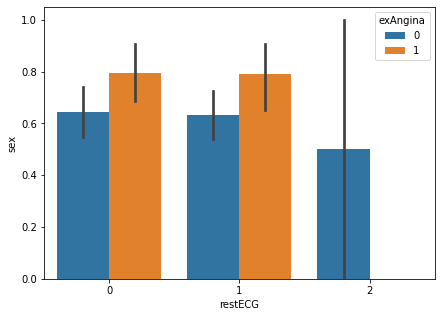

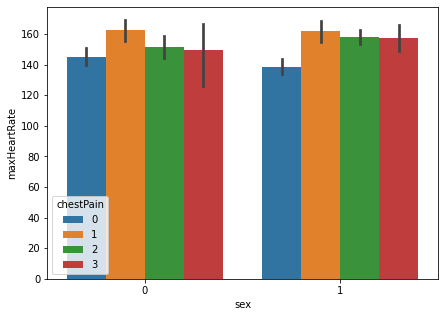

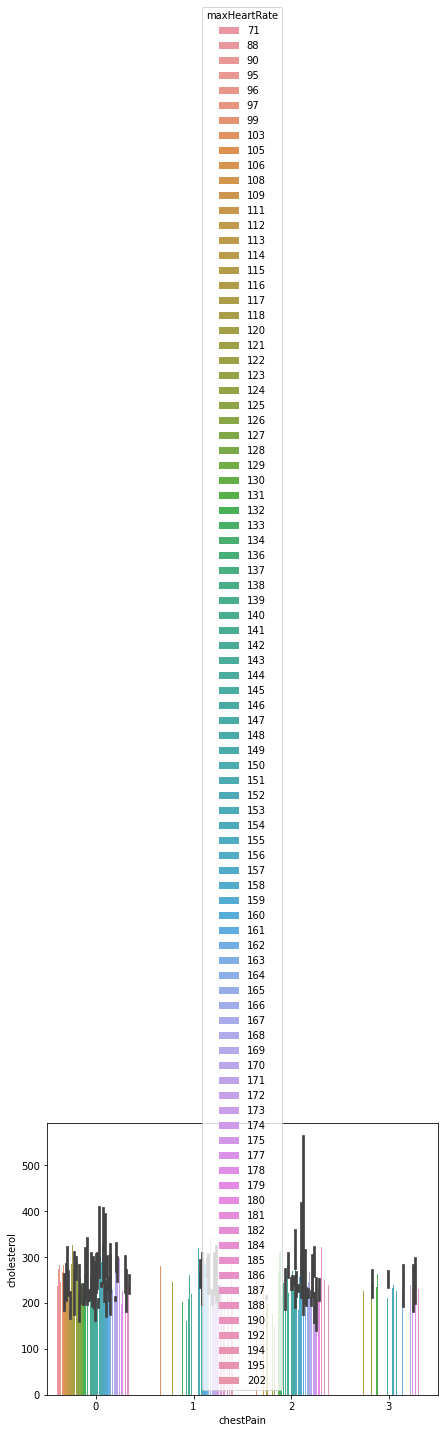

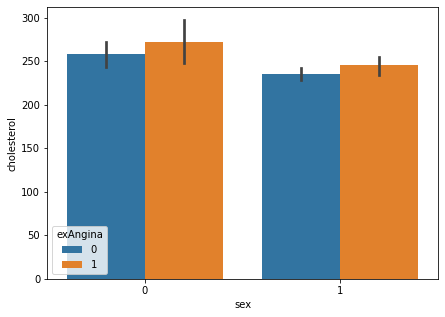

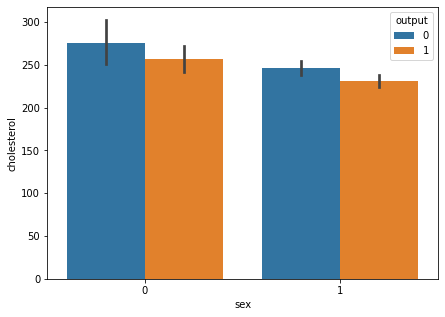

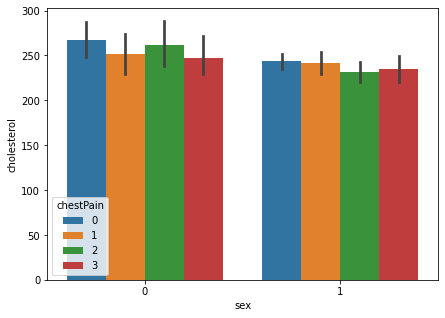

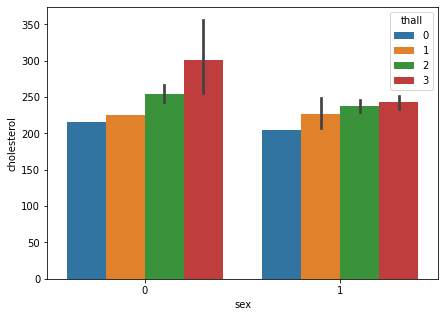

In [290]:
cols = [['restECG', 'sex', 'exAngina'], ['sex', 'maxHeartRate', 'chestPain'],
        ['chestPain', 'cholesterol', 'maxHeartRate'], 
        ['sex', 'cholesterol', 'exAngina'], ['sex', 'cholesterol', 'output'],
        ['sex', 'cholesterol', 'chestPain'], ['sex', 'cholesterol', 'thall']]

for i in cols:
    barplot(data=df, x=i[0], y=i[1], hue=i[2])

# Supervised

In [292]:
# read the dataset
import pandas as pd

df = pd.read_csv('heart.csv')

df.rename(columns = {'cp':'chestPain', 'trtbps':'restBloodP',
                              'chol':'cholesterol', 'fbs':'fastBloodS',
                              'restecg':'restECG', 'thalachh':'maxHeartRate',
                     'caa':'bloodVessel', 'exng':'exAngina'}, inplace = True)

df.drop(['slp', 'oldpeak'], axis = 1, inplace = True)

In [293]:
# assign variable for column in numeric type
final_feature_column=df.columns.tolist()
final_feature_column

['age',
 'sex',
 'chestPain',
 'restBloodP',
 'cholesterol',
 'fastBloodS',
 'restECG',
 'maxHeartRate',
 'exAngina',
 'bloodVessel',
 'thall',
 'output']

In [294]:
final_feature_column.remove('output')
final_feature_column

['age',
 'sex',
 'chestPain',
 'restBloodP',
 'cholesterol',
 'fastBloodS',
 'restECG',
 'maxHeartRate',
 'exAngina',
 'bloodVessel',
 'thall']

In [295]:
target_column = ['output']
final_column = final_feature_column+target_column
final_df = df[final_column]

In [296]:
final_df.shape

(303, 12)

In [297]:
final_df.head(10)

,age,sex,chestPain,restBloodP,cholesterol,fastBloodS,restECG,maxHeartRate,exAngina,bloodVessel,thall,output
0,63,1,3,145,233,1,0,150,0,0,1,1
1,37,1,2,130,250,0,1,187,0,0,2,1
2,41,0,1,130,204,0,0,172,0,0,2,1
3,56,1,1,120,236,0,1,178,0,0,2,1
4,57,0,0,120,354,0,1,163,1,0,2,1
5,57,1,0,140,192,0,1,148,0,0,1,1
6,56,0,1,140,294,0,0,153,0,0,2,1
7,44,1,1,120,263,0,1,173,0,0,3,1
8,52,1,2,172,199,1,1,162,0,0,3,1
9,57,1,2,150,168,0,1,174,0,0,2,1


In [298]:
# prepare the data to numpy array
final_feature_array = final_df[final_feature_column].to_numpy()
target_array = final_df[target_column].to_numpy()

In [299]:
print('shape of final feature:',final_feature_array.shape)
print('shape of target:',target_array.shape)

shape of final feature: (303, 11)
shape of target: (303, 1)


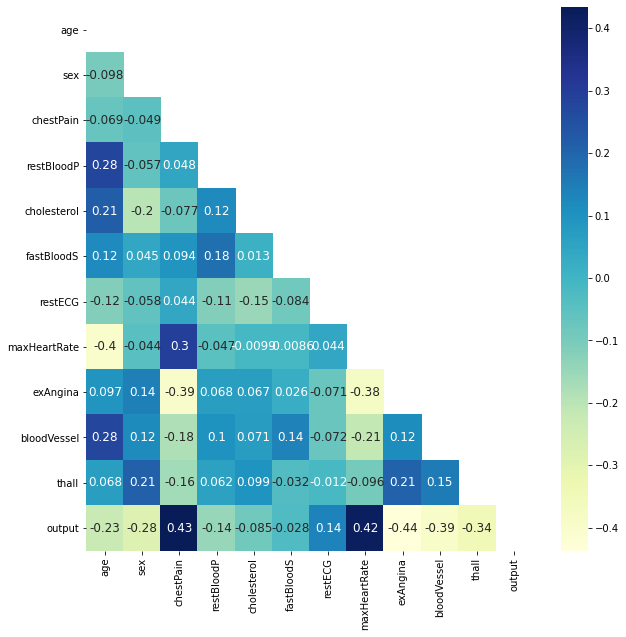

In [300]:
# check correlation between column

correlation_between_column = final_df.corr()
upper_triangle_corr = np.triu(correlation_between_column)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlation_between_column, annot = True, cmap="YlGnBu",ax=ax,annot_kws={"size":12},mask=upper_triangle_corr)

In [301]:
# import sklearn library
import sklearn.datasets as datasets
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics
import sklearn.neighbors as neighbors
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [302]:
# split the data into test and train

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    final_feature_array,
    target_array,
    train_size=0.8,
    random_state=0
    )

In [303]:
# check the shape data
print('Shape Data X Train:', X_train.shape)
print('\nShape Data X Test:', X_test.shape)
print('\nShape Data y Train:', y_train.shape)
print('\nShape Data y Test:', y_test.shape)

Shape Data X Train: (242, 11)

Shape Data X Test: (61, 11)

Shape Data y Train: (242, 1)

Shape Data y Test: (61, 1)


In [304]:
# load the algorithm
classification_model = neighbors.KNeighborsClassifier(n_neighbors=5)

In [305]:
# train the data
classification_model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [306]:
# predict the X using trained model
y_train_pred = classification_model.predict(X_train)
y_test_pred = classification_model.predict(X_test)
target_array_pred = classification_model.predict(final_feature_array)

In [307]:
# check the raw prediction data & compare with real data
print('Real Data')
print(y_train[:10])
print('\n Predicted Data')
print(y_train_pred[:10])

Real Data
[[1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]]

 Predicted Data
[1 1 1 0 1 0 0 1 1 1]


In [308]:
# check the data in the form of dataframe
final_with_pred_df = final_df.copy()
final_with_pred_df['heartAttack_predicted'] = target_array_pred.reshape(-1,)
final_with_pred_df.head(5)

,age,sex,chestPain,restBloodP,cholesterol,fastBloodS,restECG,maxHeartRate,exAngina,bloodVessel,thall,output,heartAttack_predicted
0,63,1,3,145,233,1,0,150,0,0,1,1,1
1,37,1,2,130,250,0,1,187,0,0,2,1,1
2,41,0,1,130,204,0,0,172,0,0,2,1,1
3,56,1,1,120,236,0,1,178,0,0,2,1,1
4,57,0,0,120,354,0,1,163,1,0,2,1,1


In [309]:
# evaluate classification model - accuracy
accuracy_training = metrics.accuracy_score(y_train,y_train_pred)
accuracy_test = metrics.accuracy_score(y_test,y_test_pred)

print('Accuracy Training Data: {}'.format(accuracy_training))
print('Accuracy Test Data: {}'.format(accuracy_test))

Accuracy Training Data: 0.78099173553719
Accuracy Test Data: 0.639344262295082


In [310]:
print(confusion_matrix(y_train,y_train_pred))
print(confusion_matrix(y_test,y_test_pred))

[[ 86  25]
 [ 28 103]]
[[17 10]
 [12 22]]


# Unsupervised

In [311]:
# import sklearn library
import sklearn.datasets as datasets
import sklearn.preprocessing as preprocessing
import sklearn.decomposition as decomposition
import sklearn.cluster as cluster

In [312]:
# install library
!pip install scikit-plot

In [313]:
# import graph library
import matplotlib.pyplot as plt
import scikitplot as skplt

In [314]:
# read the dataset
import pandas as pd

df = pd.read_csv('heart.csv')

df.rename(columns = {'cp':'chestPain', 'trtbps':'restBloodP',
                              'chol':'cholesterol', 'fbs':'fastBloodS',
                              'restecg':'restECG', 'thall':'maxHeartRate',
                     'caa':'bloodVessel', 'exng':'exAngina'}, inplace = True)

df.drop(['slp', 'oldpeak'], axis = 1, inplace = True)

In [315]:
# load the algorithm
pca_model = decomposition.PCA(n_components=2)

In [316]:
# assign variable for column in numeric type
final_feature_column=df.columns.tolist()
final_feature_column

['age',
 'sex',
 'chestPain',
 'restBloodP',
 'cholesterol',
 'fastBloodS',
 'restECG',
 'thalachh',
 'exAngina',
 'bloodVessel',
 'maxHeartRate',
 'output']

In [317]:
final_feature_column.remove('output')

In [318]:
final_feature_column

['age',
 'sex',
 'chestPain',
 'restBloodP',
 'cholesterol',
 'fastBloodS',
 'restECG',
 'thalachh',
 'exAngina',
 'bloodVessel',
 'maxHeartRate']

In [319]:
target_column = ['output']

In [320]:
# prepare the data to numpy array
final_feature_array = df[final_feature_column].to_numpy()
target_array = df[target_column].to_numpy()

In [321]:
print('shape of final feature:',final_feature_array.shape)
print('shape of target:',target_array.shape)

shape of final feature: (303, 11)
shape of target: (303, 1)


In [322]:
# train the data and transform
pca_feature_array = pca_model.fit_transform(final_feature_array)

In [323]:
# check the shape of the result
pca_feature_array.shape

(303, 2)

In [324]:
# add new name for the new column
pca_column = ['pca column 1','pca column 2']

In [325]:
# transform to dataframe
pca_feature_df = pd.DataFrame(pca_feature_array,columns=pca_column)
pca_feature_df['output'] = target_array

In [326]:
# check the resulted data
pca_feature_df.head(5)

,pca column 1,pca column 2,output
0,-12.269213,2.833287,1
1,2.686976,-39.938883,1
2,-42.950527,-23.643918,1
3,-10.944198,-28.432176,1
4,106.979916,-15.856773,1


In [327]:
# check the explained variance
print('explained variance:',pca_model.explained_variance_ratio_)

explained variance: [0.74792122 0.15037767]


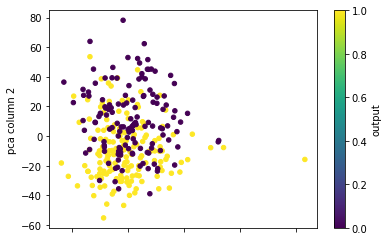

In [328]:
# show in 2D plot
pca_feature_df.plot.scatter(x='pca column 1',y='pca column 2',c='output',colormap='viridis')

In [329]:
# check explained variance for each number of component
for x in range(1,len(final_feature_column)+1):
  pca_model_x = decomposition.PCA(n_components=x)
  pca_feature_array_x = pca_model_x.fit_transform(final_feature_array)
  print('explained variance for {} components: {}'.format(x,np.sum(pca_model_x.explained_variance_ratio_)))

explained variance for 1 components: 0.7479212200752402
explained variance for 2 components: 0.8982988923575894
explained variance for 3 components: 0.9829286809614447
explained variance for 4 components: 0.9991522370828333
explained variance for 5 components: 0.999465248840896
explained variance for 6 components: 0.999695900467656
explained variance for 7 components: 0.9997995670238212
explained variance for 8 components: 0.9998754326936843
explained variance for 9 components: 0.9999260290932055
explained variance for 10 components: 0.9999680251971824
explained variance for 11 components: 0.9999999999999997


In [330]:
# load the algorithm
cluster_model = cluster.KMeans(n_clusters=2)

In [331]:
# train the data
cluster_array = cluster_model.fit(final_feature_array)

In [332]:
# label result
cluster_label = cluster_model.labels_
cluster_label

array([1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,

In [333]:
# add label to final dataframe
df['cluster'] = cluster_label

In [334]:
# check the resulted data
df.head(5)

,age,sex,chestPain,restBloodP,cholesterol,fastBloodS,restECG,thalachh,exAngina,bloodVessel,maxHeartRate,output,cluster
0,63,1,3,145,233,1,0,150,0,0,1,1,1
1,37,1,2,130,250,0,1,187,0,0,2,1,1
2,41,0,1,130,204,0,0,172,0,0,2,1,1
3,56,1,1,120,236,0,1,178,0,0,2,1,1
4,57,0,0,120,354,0,1,163,1,0,2,1,0


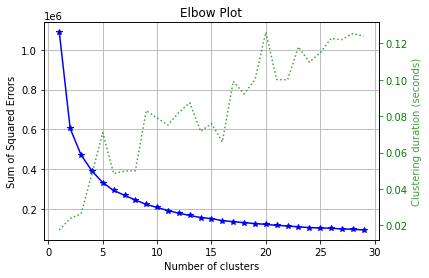

In [335]:
# check using elbow method to define the best cluster
skplt.cluster.plot_elbow_curve(cluster_model, final_feature_array, cluster_ranges=range(1, 30))
plt.show()

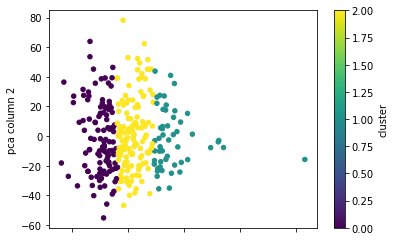

In [336]:
# plot using PCA using the best cluster
best_cluster_model = cluster.KMeans(n_clusters=3)
best_cluster_array = best_cluster_model.fit(final_feature_array)
best_cluster_label = best_cluster_model.labels_
pca_feature_df = pd.DataFrame(pca_feature_array,columns=pca_column)
pca_feature_df['cluster'] = best_cluster_label
pca_feature_df.plot.scatter(x='pca column 1',y='pca column 2',c='cluster',colormap='viridis')